In [1]:
from google.colab import files
  
  
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt
Saving val.txt to val.txt


In [2]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

from sklearn.metrics import roc_auc_score

!pip install contractions
import contractions

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     |████████████████████████████████| 327kB 5.9MB/s 
     |████████████████████████████████| 286kB 37.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85406 sha256=3a1a14fbe744519622a7171fc8ba841b56a9d34f454c1b6d3c2b009f6148154b
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [4]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from collections import defaultdict

In [5]:
train_data = pd.read_csv(io.BytesIO(uploaded['train.txt']), header = None)
train_data.head()

,0
0,i didnt feel humiliated;sadness
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wro...
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy;anger


In [6]:
test_data = pd.read_csv(io.BytesIO(uploaded['test.txt']), header = None)
test_data.head()

,0
0,im feeling rather rotten so im not very ambiti...
1,im updating my blog because i feel shitty;sadness
2,i never make her separate from me because i do...
3,i left with my bouquet of red and yellow tulip...
4,i was feeling a little vain when i did this on...


In [7]:
validation_data = pd.read_csv(io.BytesIO(uploaded['val.txt']), header = None)
validation_data.head()

,0
0,im feeling quite sad and sorry for myself but ...
1,i feel like i am still looking at a blank canv...
2,i feel like a faithful servant;love
3,i am just feeling cranky and blue;anger
4,i can have for a treat or if i am feeling fest...


separating emotions from text

In [8]:
def separate_emotion(dataset):

    dataset[["text", "emotion"]] = dataset[0].str.split(";", expand = True)
    dataset = dataset.drop(0, axis = 1)
    
    return dataset

In [9]:
train_data = separate_emotion(train_data)
validation_data = separate_emotion(validation_data)
test_data = separate_emotion(test_data)

In [10]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


general information about the data before starting the cleaning process like data type, presence of null value,unique emotions and their count.

In [11]:
train_data.dtypes, validation_data.dtypes, test_data.dtypes

(text       object
 emotion    object
 dtype: object, text       object
 emotion    object
 dtype: object, text       object
 emotion    object
 dtype: object)

In [12]:
train_data.isna().any(), validation_data.isna().any(), test_data.isna().any()

(text       False
 emotion    False
 dtype: bool, text       False
 emotion    False
 dtype: bool, text       False
 emotion    False
 dtype: bool)

In [13]:
print("Unique emotions in training set: ", train_data.emotion.unique())
train_data.emotion.value_counts()

Unique emotions in training set:  ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [14]:
print("Unique emotions in validation set: ", test_data.emotion.unique())
test_data.emotion.value_counts()

Unique emotions in validation set:  ['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']


joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: emotion, dtype: int64

In [15]:
print("Unique emotions in testing set: ", validation_data.emotion.unique())
validation_data.emotion.value_counts()

Unique emotions in testing set:  ['sadness' 'love' 'anger' 'joy' 'fear' 'surprise']


joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: emotion, dtype: int64

visualization of unique emotion count.

In [16]:
def emotion_counts(dataset, title = None):
    plt.figure(figsize = (6, 4))
    plt.bar((dataset.groupby("emotion").size()).index, dataset.groupby("emotion").size(), 
            color= ["red", "purple", "royalblue", "pink", "green", "gold"])
    if title is not None:
        plt.title(title)
    plt.show()

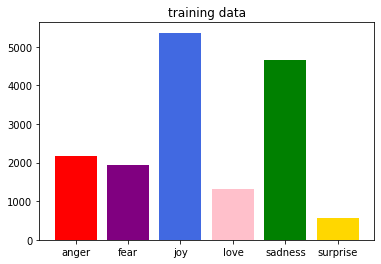

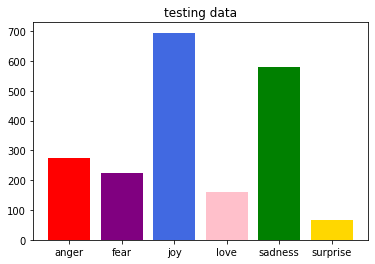

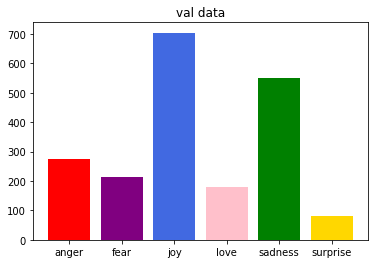

In [17]:
emotion_counts(train_data, "training data")
emotion_counts(test_data, "testing data")
emotion_counts(validation_data, "val data")

In [18]:
data_total = [train_data,validation_data,test_data]

Cleaning of data:
using stopword present in NLTK(natual language toolkit) to remove common english words(a,an,the,are,etc) programmed to ignore. this helps in focusing more on the exact emotion and saves extra space in our dataset or taking up processing time.

In [19]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [20]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [21]:
stop_words = set(stopwords.words('english')) 
stem = WordNetLemmatizer ()
def clean_text(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [contractions.fix(word) for word in text]
    text = [stem.lemmatize(w,tag_map[tag[0]]) for w, tag in pos_tag(text) if w not in stop_words]
    return " ".join(text)

In [22]:
for i,data in enumerate(data_total):
    data.text = data.text.apply(clean_text)

Encoding target variables

In [23]:
laberEncoder = LabelEncoder()
laberEncoder.fit(train_data.emotion)
for i,data in enumerate(data_total):
    data.emotion = laberEncoder.transform(data.emotion)

vectorization of data and using tensorflow to work on these vectors as it provides large number of functions to process this data. 

TF-IDF is a strategy of understanding text by scoring relative importance of the word. TF-IDF is the combination of TF(term frequency : The number of times a word appears in a document divded by the total number of words in the document.) and IDF(inverse data frequency: determines the weight of rare words across all documents in the corpus.) hence it provides the scores for all the words in a corpus. Rather than manually implementing TF-IDF ourselves, we could use the class provided by sklearn.

In [24]:
#finding the score of words in train data
vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1, 2))
vectors = vectorizer.fit_transform(train_data.text)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()  #creating a dense vector
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [25]:
#finding the score of words in validation data
vectors = vectorizer.transform(validation_data.text)
dense = vectors.todense()
denselist = dense.tolist()
df_valfeature = pd.DataFrame(denselist, columns=feature_names)

Prediction using ML model

In [26]:
class EnsembleHelper(object):
    def __init__(self,models,seed=42,params=None,cv=5):
        self.seed = seed
        self.params = params
        
        
    def gridSearchCV(self,estimator,params,X_train,Y_train):
        if not params :
            params = {}
        #clf = SGDClassifier(loss='hinge', max_iter=100)
        #calibrated_clf = CalibratedClassifierCV(base_estimator=estimator, method='sigmoid', cv=5)
        grid = GridSearchCV(estimator=estimator, param_grid=params, cv=5)
        grid.fit(X_train,Y_train)
        rf_best = grid.best_estimator_
        print(estimator,grid.best_params_,grid.best_score_,sep="|")
        return rf_best
        
    
    def fit(self, X_train,Y_train):
        ensemblemodel = []
        for key , estimator in models:
            Dict = {search_key.split("__")[1]:val for search_key, val in self.params.items() if search_key.startswith(key)}
            bestmodel = self.gridSearchCV(estimator,Dict,X_train,Y_train)
            final = (key , bestmodel)
            ensemblemodel.append(final)
        
        self.clf = VotingClassifier(estimators=ensemblemodel,voting='soft')
        self.clf.fit(X_train,Y_train)
        
        
    def predict(self,X_test):
      predictions = self.clf.predict(X_test)
      return predictions
        
    def score(self,X_test,Y_test):
        return self.clf.score(X_test,Y_test) 

In [27]:
models = [
    ('lr' , LogisticRegression(random_state=0,max_iter=10000)),
    ('mnb', MultinomialNB()),
    ('nb',BernoulliNB()),
    ('rf',RandomForestClassifier())
]

params = {'lr__C': [0.1,1.0,10.0],
          'mnb__alpha': np.linspace(0.0, 1.0, 5),
          'nb__alpha': np.linspace(0.0, 1.0, 5),
          'rf__criterion' : ['gini', 'entropy']}

In [28]:
ensemble = EnsembleHelper(models,cv=5,params=params)
#clf = ensemble.fit(df, train_data.emotion)
#calibrator = CalibratedClassifierCV(ensemble, cv='prefit')
ensemble.fit(df, train_data.emotion)
predict = ensemble.predict(df_valfeature)
print("Ensemble score : ",ensemble.score(df_valfeature,validation_data.emotion))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)|{'C': 10.0}|0.787625
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)|{'alpha': 0.0}|0.7693125000000001
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)|{'alpha': 0.25}|0.781625
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_sc